In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import ast
import matplotlib.pyplot as plt

# Config

In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = 416
scale = 1.1
TRAIN_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-train/sequences/"
VAL_IMAGE_ROOTPATH = "D:visdrone/VisDrone2019-MOT-val/sequences/"

# make data generator

In [30]:
train_df = pd.read_csv("EDA/train_det_df.csv")
val_df = pd.read_csv("EDA/val_det_df.csv")

In [31]:
print(train_df.shape)
train_df.head(2)

(24198, 10)


,video_name,frame_index,img_path,coco,xyxy,yolo,height,width,classes,unified_classes
0,uav0000013_00000_v,1,uav0000013_00000_v/0000001.jpg,"[[0.4412202380952381, 0.056878306878306875, 0....","[[0.4412202380952381, 0.056878306878306875, 0....","[[0.5059523809523809, 0.18253968253968256, 0.1...",756,1344,"[0, 0, 1, 1, 7, 1, 1, 10, 1, 10, 10, 10, 1, 2,...","[0, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, ..."
1,uav0000013_00000_v,2,uav0000013_00000_v/0000002.jpg,"[[0.44047619047619047, 0.056878306878306875, 0...","[[0.44047619047619047, 0.056878306878306875, 0...","[[0.5052083333333334, 0.18187830687830686, 0.1...",756,1344,"[0, 0, 1, 1, 7, 1, 1, 10, 1, 10, 10, 10, 1, 2,...","[0, 0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, ..."


In [32]:
train_df["img_path"] = train_df["img_path"].apply(lambda x : TRAIN_IMAGE_ROOTPATH+x )
train_df["yolo"] = train_df["yolo"].apply(lambda x : ast.literal_eval(x))
train_df["classes"] = train_df["classes"].apply(lambda x : ast.literal_eval(x))

train_df = train_df[["img_path", "yolo", "height","width","classes"]]
train_df.head(2)

,img_path,yolo,height,width,classes
0,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[0.5059523809523809, 0.18253968253968256, 0.1...",756,1344,"[0, 0, 1, 1, 7, 1, 1, 10, 1, 10, 10, 10, 1, 2,..."
1,D:visdrone/VisDrone2019-MOT-train/sequences/ua...,"[[0.5052083333333334, 0.18187830687830686, 0.1...",756,1344,"[0, 0, 1, 1, 7, 1, 1, 10, 1, 10, 10, 10, 1, 2,..."


In [43]:
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=["category_ids"],),
)

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=["category_ids"]),
)

C:\Users\rh987\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:346: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


In [44]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, transformer, batch_size=4, train=False, size=416):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.batch_size = batch_size
        self.size = size
        self.transformer = transformer

    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)

    def on_epoch_end(self):
        if self.train:
            self.df = self.df.sample(frac=1.0).reset_index(drop=True)

    def __getitem__(self, idx):
        image_path_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
                                        self.batch_size].img_path.values
        boxes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
                                   self.batch_size].yolo.values
        classes_batch = self.df.iloc[idx * self.batch_size:(idx + 1) *
                                     self.batch_size].classes.values

        X = np.zeros((image_path_batch.shape[0], self.size, self.size, 3))
        Y = []
        for i in range(image_path_batch.shape[0]):
            image = cv2.imread(image_path_batch[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            boxes = boxes_batch[i]
            classes = classes_batch[i]
            
            transformed = self.transformer(image=image, bboxes=boxes,category_ids=classes)
            image = transformed["image"] / 255.0
            boxes = transformed["bboxes"]

            X[i, ] = image
            Y.append(boxes)
        return X, Y

In [61]:
train_gen = DataGenerator(train_df, transformer=train_transforms, batch_size=20, train=True, size=IMAGE_SIZE)

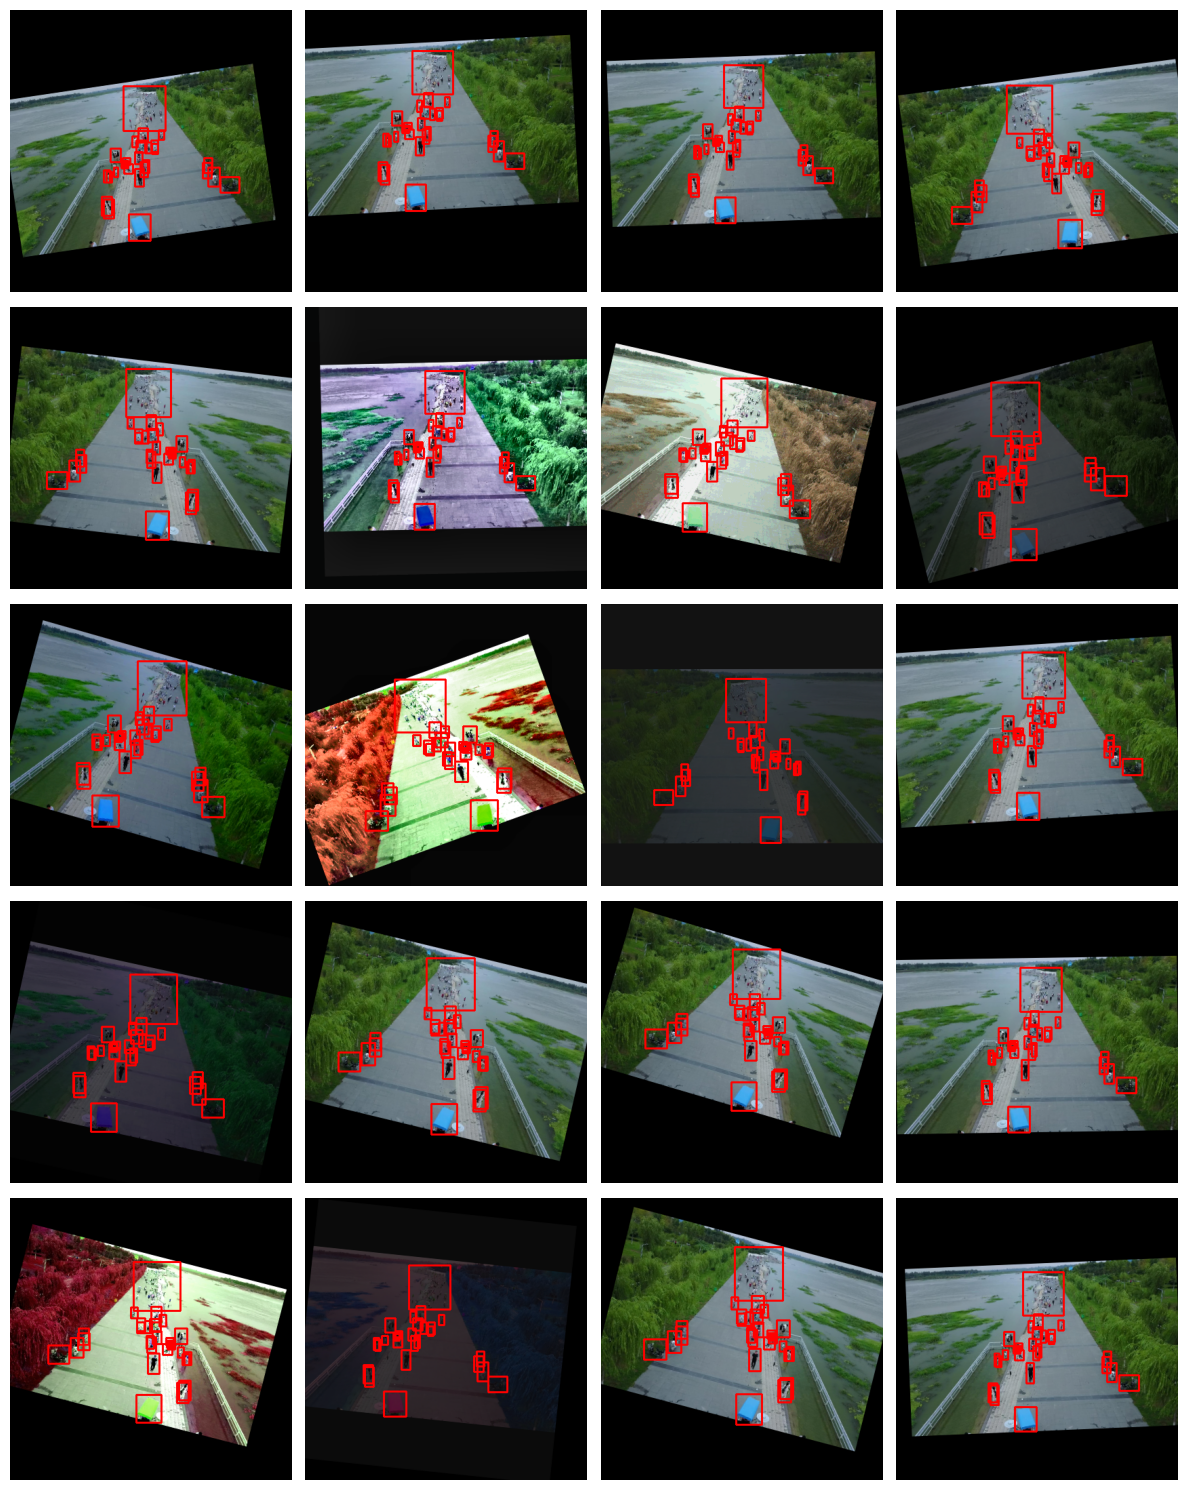

In [63]:
def yolo2xyxy(box):
    x,y,w,h = box
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

def visualize_bbox(img, bbox, color=(255, 0, 0), thickness=2, size=416):
    """Visualizes a single bounding box on the image"""
    bbox = yolo2xyxy(bbox)
    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin*size)
    ymin = int(ymin*size)
    xmax = int(xmax*size)
    ymax = int(ymax*size)
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax),color=color,thickness=thickness)
    return img

def visualize(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    return img

for x,y in train_gen:
    img_count = x.shape[0]
    col_len = int(img_count // 4)
    col_len = col_len if col_len else 1
    plt.figure(figsize=(12,3*col_len))
    
    for i in range(x.shape[0]):
        image = x[i]*255
        image = image.astype(np.uint8)
        boxes = y[i]
        img = visualize(image, boxes)
        plt.subplot( col_len, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break